In [1]:
import numpy as np
import torch
from data_gen import *
from BP import *
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from DNN_BP import *

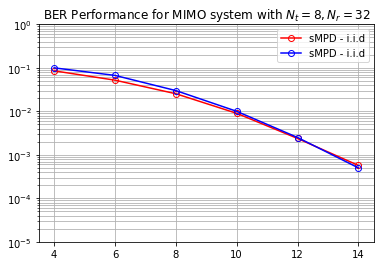

In [2]:
# CHEMP in 8 x 32 Configuration 

Nt, Nr, L = 8, 32, 8
delt = 0.60
given_BER = np.array([1e-1, 6.7e-2, 3e-2, 1e-2, 2.5e-3, 5e-4])  # 8x32 

batch = 500
Es = 10
Rx, Tx = 0.0, 0.0
SNR = np.arange(4,15,2)
noise_var = noise_variance(SNR, Es, Nt)
device = torch.device('cuda:0')

num = 0
flag = 0
BER = np.zeros((6))
ER  = np.zeros((6))

s = torch.tensor([-3.0, -1.0, 1.0, 3.0], device=device).view(4,1)

while (num<100):
    num += 1
    for noise in noise_var:
        y, x, H = data_gen_16QAM(batch, Nt, Nr, noise, Rx, Tx, device)
        
        P = torch.ones(size=(batch, 2*Nt, 4), device=device)*0.25
        z, J, var_j = sMPD_transform(y, H, P, noise, Nr, device)
        
        for l in range(L):
            x_p, P = sMPD_16QAM_layer(z, J, P, 1.0, 0.0, delt, var_j, device)
        
        ER[flag%6] += torch.sum(torch.squeeze(x_p) != torch.squeeze(x.cuda()))
        BER[flag%6] = ER[flag%6]/(batch*4*Nt*(num))
        
        flag += 1        
    
    line1 = plt.plot(SNR, BER,c='red', ls='-', marker='o', mfc='none')
    line2 = plt.plot(SNR, given_BER,c='blue', ls='-', marker='o', mfc='none')
    plt.yscale('log')
    plt.title('BER Performance for MIMO system with $N_{t} = 8, N_{r} = 32$')
    plt.grid(True, which = 'both')
    plt.ylim(1e-5, 1e0)
    plt.legend(('sMPD - i.i.d','sMPD - i.i.d'))
    
    clear_output(wait = True)
    plt.pause(0.01)